In [241]:
%load_ext autoreload
%autoreload 2
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, pickle, pyemma as py, sys, os
import pandas as pd
import seaborn as sns 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
%matplotlib inline
from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
lag_time = 10
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
tf.__version__

'1.14.0'

In [249]:
# load pairwise distances and dihedral angles computed from simulation trajectory

thermo_features = np.load('/home/pme/srv/srv/dna_data/thermo-332-1000-10.npy')
pwd_features = np.load('/home/pme/srv/srv/dna_data/pwd-332-1000-190.npy')

scaler = pre.MinMaxScaler(feature_range=(-1, 1))

scaler.fit(np.concatenate(thermo_features))
thermo_features_s = [scaler.transform(item) for item in thermo_features]

scaler.fit(np.concatenate(pwd_features))
pwd_features_s = [scaler.transform(item) for item in pwd_features]

print(np.shape(thermo_features))
print(np.shape(pwd_features))


(332, 1000, 10)
(332, 1000, 190)


## HDE

In [153]:
skip = 1
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

'''
## for default pairwise setup
hde = HDE(45, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=50000, n_epochs=200, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])

## for thermo basepair features
hde = HDE(2, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=5000, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])
          
'''
hde = HDE(190, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=5000, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])


In [42]:
# hde.r_degree = 10    # pre-training, to speed up discovery of first few slowest modes
# hde.batch_size = 200000
# hde.n_epochs = 50
# hde.fit(pairwise_dis_s)
# hde._recompile = True
# hde.r_degree = 5
# hde.fit(pairwise_dis_s)
# hde.batch_size = 500000
# hde._recompile = True
# hde.r_degree = 2
# hde.n_epochs = 100
# hde.fit(pairwise_dis_s)

In [115]:
hde.r_degree = 2
hde.n_epochs = 100
hde.fit(np.concatenate(pwd_features))

Train on 265592 samples, validate on 66398 samples
Epoch 1/100
265592/265592 [==============================] - 7s 26us/step - loss: -3.0655 - val_loss: -3.2521
Epoch 2/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.2516 - val_loss: -3.2133
Epoch 3/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.2465 - val_loss: -3.2818
Epoch 4/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.2949 - val_loss: -3.1982
Epoch 5/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.3085 - val_loss: -3.3227
Epoch 6/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.3458 - val_loss: -3.3795
Epoch 7/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.3750 - val_loss: -3.3820
Epoch 8/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.3767 - val_loss: -3.4085
Epoch 9/100
265592/265592 [==============================] - 4s 14us/

265592/265592 [==============================] - 4s 14us/step - loss: -3.4635 - val_loss: -3.4600
Epoch 75/100
265592/265592 [==============================] - 4s 16us/step - loss: -3.4488 - val_loss: -3.4564
Epoch 76/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.4683 - val_loss: -3.4719
Epoch 77/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.4698 - val_loss: -3.4598
Epoch 78/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.4604 - val_loss: -3.4651
Epoch 79/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.4577 - val_loss: -3.4645
Epoch 80/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.4592 - val_loss: -3.4640
Epoch 81/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.4518 - val_loss: -3.4580
Epoch 82/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.4368 - val_loss: -3.3810
Epoch 83/100
2

HDE(activation=None, batch_normalization=True, batch_size=5000,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7f28b5f8ee48>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=190,
    l2_regularization=0.0, lag_time=10, latent_space_noise=0,
    learning_rate=0.01, n_components=3, n_epochs=100, validation_split=0.2,
    verbose=True)

In [116]:
hde_coords = [hde.transform(item) for item in pwd_features]
hde_timescales = hde.timescales_
print(hde_timescales)

[157.8024661   94.44493567  81.41508347]


In [253]:
## make data frame

skip = 50    #num coords to skip on plot

hde_coords_conc = np.concatenate(hde_coords[::skip])
thermo_features_conc = np.concatenate(thermo_features[::skip])

index_size = len(hde_coords_conc[:, 0])
print (np.shape(hde_coords_conc))
print (np.shape(thermo_features_conc))

df_hde = pd.DataFrame(data    = hde_coords_conc, 
                   columns = ['1st_sm', '2nd_sm', '3rd_sm'], 
                   index   = np.linspace(1, index_size, index_size))

feature_col_list = ['Step', 'nbp', 'E_bond', 'E_angle', 'E_dihed', 'ebp', 'ecstk', 'eexcl', 'dna_ecou', 'Temp']

#make additional df column for timestep
lin_x = [i for i in range(len(thermo_features[0]))] 
lin_x_list = []
for i in range(len(thermo_features)):
    lin_x_list.append(lin_x)
    
lin_x_conc = np.concatenate(lin_x_list[::skip])
print(np.shape(lin_x_conc))

df_thermo =  pd.DataFrame(data    = thermo_features_conc, 
                   columns = feature_col_list, 
                   index   = np.linspace(1, index_size, index_size))

df_thermo['time_traj'] = lin_x_conc
                          
df = df_hde.join(df_thermo)

print(df.head())

(7000, 3)
(7000, 10)
(7000,)
       1st_sm    2nd_sm    3rd_sm       Step  nbp    E_bond    E_angle  \
1.0 -0.643964  0.934143  1.372138  3445400.0  8.0  7.404099 -26.338123   
2.0 -0.643964  0.934143  1.372138  3445600.0  5.0  7.366535 -28.001428   
3.0 -0.509291  0.485489  1.365723  3445800.0  8.0  7.458021 -28.548777   
4.0 -0.643964  0.934143  1.372138  3446000.0  8.0  7.922476 -20.518769   
5.0 -0.643964  0.934143  1.372138  3446200.0  9.0  7.468203 -23.194835   

       E_dihed        ebp     ecstk     eexcl  dna_ecou       Temp  time_traj  
1.0 -39.012433 -33.366231 -6.699327  0.645086  6.026676  395.42529          0  
2.0 -38.324502 -32.913029 -5.741455  0.059759  5.661966  362.32443          1  
3.0 -38.659884 -32.157498 -6.233881  0.000000  5.981081  315.14877          2  
4.0 -38.745190 -35.273236 -5.722497  0.006261  6.254908  275.25456          3  
5.0 -39.969359 -36.392857 -6.054198  0.054759  6.639332  330.89508          4  


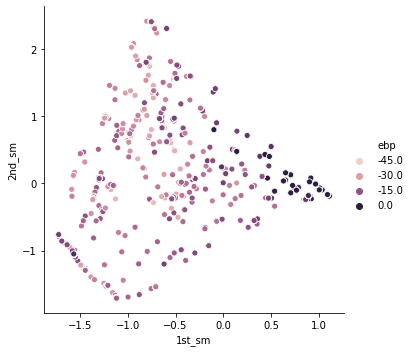

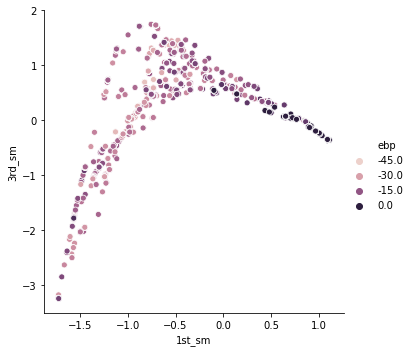

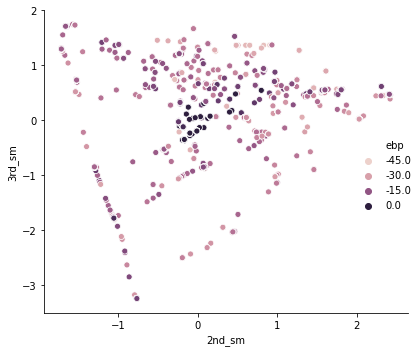

In [254]:
## Graphing slow modes and using physical properties as color gradients
## thermo_features index: 
# Step(0) nbp(1) E_bond(2) E_angle(3) E_dihed(4) ebp(5) ecstk(6) eexcl(7) dna_ecou(8) Temp(9)

#f, axes = plt.subplots(3, 1)
#sns.despine(left=True)

sns.relplot(data = df,
            x = "1st_sm", 
            y = "2nd_sm", 
            hue = "ebp",
            #ax=axes[0]
            )

sns.relplot(data = df,
            x = "1st_sm", 
            y = "3rd_sm", 
            hue = "ebp",
            #ax=axes[1]
            )

sns.relplot(data = df,
            x = "2nd_sm", 
            y = "3rd_sm", 
            hue = "ebp",
            #ax=axes[2]
            )

plt.tight_layout()
#plt.show()


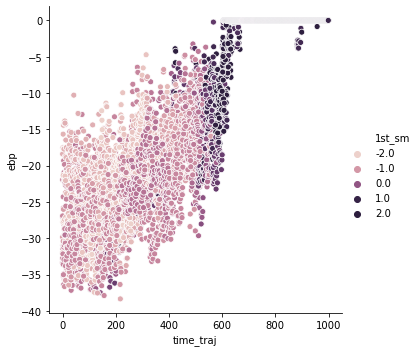

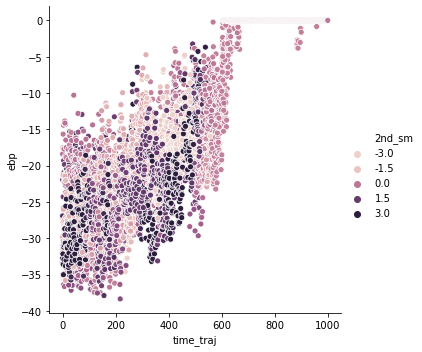

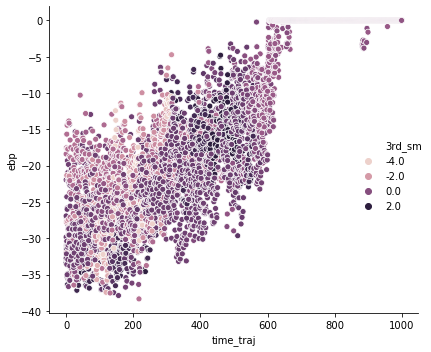

In [255]:
## Graphing physical property comparisons and using slow modes as color gradient
## thermo_features index: 
# Step(0) nbp(1) E_bond(2) E_angle(3) E_dihed(4) ebp(5) ecstk(6) eexcl(7) dna_ecou(8) Temp(9) time_traj (10)

sns.relplot(data = df,
            x = "time_traj", 
            y = "ebp", 
            hue = "1st_sm",
            )

sns.relplot(data = df,
            x = "time_traj", 
            y = "ebp", 
            hue = "2nd_sm",
            )

sns.relplot(data = df,
            x = "time_traj", 
            y = "ebp", 
            hue = "3rd_sm",
            )

plt.tight_layout()

